<h1>Working with Page-Level Metadata from HathiTrust<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Test-feature-reader-on-sample-volume" data-toc-modified-id="Test-feature-reader-on-sample-volume-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test feature-reader on sample volume</a></span></li><li><span><a href="#Connect-to-data-API-and-identify-pages-with-images" data-toc-modified-id="Connect-to-data-API-and-identify-pages-with-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Connect to data API and identify pages with images</a></span></li><li><span><a href="#Selecting-from-Pandas-dataframe-with-image_pages-list" data-toc-modified-id="Selecting-from-Pandas-dataframe-with-image_pages-list-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Selecting from Pandas dataframe with image_pages list</a></span><ul class="toc-item"><li><span><a href="#Frequency-of-&quot;picture&quot;-on-pages-with-images" data-toc-modified-id="Frequency-of-&quot;picture&quot;-on-pages-with-images-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Frequency of "picture" on pages with images</a></span></li></ul></li><li><span><a href="#Word-Embeddings" data-toc-modified-id="Word-Embeddings-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Word Embeddings</a></span><ul class="toc-item"><li><span><a href="#Build-dictionary-from-volumes" data-toc-modified-id="Build-dictionary-from-volumes-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Build dictionary from volumes</a></span></li><li><span><a href="#Turn-page-token-counts-into-BoW-format" data-toc-modified-id="Turn-page-token-counts-into-BoW-format-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Turn page token counts into BoW format</a></span></li></ul></li><li><span><a href="#Visualize-page-page-semantic-similarity" data-toc-modified-id="Visualize-page-page-semantic-similarity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize page-page semantic similarity</a></span></li><li><span><a href="#TODO" data-toc-modified-id="TODO-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TODO</a></span></li><li><span><a href="#Bibliography-and-further-reading" data-toc-modified-id="Bibliography-and-further-reading-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Bibliography and further reading</a></span></li></ul></div>

# Introduction

Welcome! In this notebook we will download and merge page-level metadata from two HathiTrust volumes in order to test a simple hypothesis about 19C picture books. I have also included a more advanced task: comparing semantic and visual similarity in cases of illustration reuse. Follow this link for up-to-date information on how to clone the repo and get the notebook working.

> https://github.com/StephenKrewson/page-level-features

Our first lines of code will import the necessary libraries. Even though our kernel is Python2.7 (due to the `hathidata` compatibility issue), we want to stick with the Python3 format for printing.

In [51]:
from __future__ import print_function
from collections import defaultdict
from config import ht_keys as ht

from gensim.corpora import Dictionary
import gensim.downloader as api
from gensim.matutils import softcossim
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity, SoftCosineSimilarity

from hathidata.api import HathiDataClient
from htrc_features import FeatureReader

from itertools import chain
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

# See: http://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib notebook
sns.set()

# Test feature-reader on sample volume

Let's assign a HathiTrust volume id (htid) string to a variable. When browsing HathiTrust.org, the htid can be found in the URL. Feel free to use a different volume, though it may be anticlimactic if you pick one without any images! The feature reader object needs to be initialized with array of volumes so we wrap `vol_id` inside brackets. We can iterate over this array to check out the title of our sample volume, which should be "The tales of Peter Parley about America."

In [52]:
# htid of our sample volumes
vol_ids = ["hvd.32044021161005","osu.32435078698222"]

# See docs: https://github.com/htrc/htrc-feature-reader
# we can pass in a *list* of paths as ids and download
# directly from data API without pre-fetching with rsync 
fr = FeatureReader(ids=vol_ids)

# basic metadata about our volumes
# See: https://github.com/htrc/htrc-feature-reader#volume
for vol in fr:
    print(vol.title, vol.year, vol.page_count, "pages,", vol.handle_url)
    
# we'll mostly work with the first volume from 1830
parley1830 = fr.first()

The tales of Peter Parley about America. 1830 130 pages, http://hdl.handle.net/2027/hvd.32044021161005
The tales of Peter Parley about America. 1827 150 pages, http://hdl.handle.net/2027/osu.32435078698222


# Connect to data API and identify pages with images

Now that feature-reader is working, let's interact with the data API. Why two different libraries? Well, feature-reader is developed by HTRC, which is the research center for HathiTrust. The HTRC team focuses on cutting-edge ways of encapsulating and using data on large scales and both in and out of copyright.

The RESTful data API, on the other hand, is more conventional and has been around much longer (it was most recently updated in 2015). Since HTRC has not yet focused on image processing, we need to use the older API for finding images. This is not a disadvantage since the regular data API allows access to some special page features that Google has been sharing with HathiTrust. Tom Burton-West, a research librarian at Michigan, explained to me that . . . (TODO).

If you followed the steps in the README, you will already have a `config.py` file with valid access tokens. 

In [53]:
# establish a connection to the API
access_key = ht['access_key']
secret_key = ht['secret_key']
data_api = HathiDataClient(access_key, secret_key)

Once we authenticate to the client, we can get the full volume metadata for our sample book. The page metadata is nested within the volume metadata via the sequence map. The sequence consists of the ordered set of page images. A page in this sense does not necessarily belong to the book's pagination in the bibliographic sense. The sequence includes the covers and pastedowns and endpapers and anything else (possibly mistakes or duplicates) that would show up in a full scan of a physical witness copy.

As we will see, feature-reader only works on a subset of the sequence: namely, all the "pages" with OCR text. The data API does very little filtering. This is great because we can filter using the `htd:pfeat` field, which is a per-page list of features calculated by Google after the full-text OCR. The range of features that appear for at least one page show that Google is interested in extracting the chapter scheme from the book and the location of paratextual aids like the table of contents.  

In [54]:
# grab the volume metadata for 1830 Tales about America
vol_meta = json.loads(data_api.request_vol_meta(vol_ids[0], "json"))

# sequence gets us each page of the PDF in order, with any
# additional information that might be available for it
sequence = vol_meta['htd:seqmap'][0]['htd:seq']

# list comprehension for pages with "IMAGE_ON_PAGE" in the htd:pfeat array
image_pages = [int(page['pseq']) for page in sequence if 'IMAGE_ON_PAGE' in page['htd:pfeat']]
print("Pages in sequence with images:", image_pages)

# set of all features that appear in this volume
vol_features = set(chain.from_iterable([page['htd:pfeat'] for page in sequence]))
print("\nAll feature types appearing in this volume:", vol_features)

Pages in sequence with images: [1, 2, 7, 14, 16, 17, 18, 19, 22, 27, 33, 35, 37, 44, 45, 46, 47, 48, 49, 52, 55, 57, 58, 59, 60, 61, 65, 68, 69, 71, 73, 74, 76, 80, 86, 88, 103, 128, 129, 130]

All feature types appearing in this volume: set([u'TITLE', u'IMPLICIT_PAGE_NUMBER', u'FIRST_CONTENT_CHAPTER_START', u'PAGE_TURNBACK', u'FRONT_COVER', u'UNTYPICAL_PAGE', u'TABLE_OF_CONTENTS', u'BACK_COVER', u'BLANK', u'E', u'A', u'C', u'B', u'IMAGE_ON_PAGE', u'G', u'I', u'M', u'L', u'N', u'P', u'R', u'U', u'T', u'CHAPTER_START', u'Y', u'_'])


# Selecting from Pandas dataframe with image_pages list

The idea is to use `image_pages` as a list of indices for selecting from the data we get from feature-reader. The feature-reader data comes from a giant extracted features project and is very fast to access, unlike the data API. So we want to do the image discovery up front.

Feature-reader uses Pandas dataframes that allow relational database-style selection of rows. We build a document-term matrix in which the page sequence numbers are the row indices. The columns are tokens, NLP-speak for "words". Let's notate this matrix as $PTC$ for "page by term count." Then $PTC_{ij}$ contains the number of times word $j$ appears on page $i$.

We use the `reindex` method to ensure that even if some of the requested page indices don't exist, no errors will be thrown. For instance, `image_pages` says that page 1 in the sequence contains an image. Page 1 is the front cover so it's arguably not a page image and ut's definitely not in the returned pages from the `term_page_freqs` method. Just to be safe, on line 10, we also drop rows containing "not a number" or `NaN`.

Notice how seamlessly the notebook displays Pandas dataframes! Notice also that feature-reader is NOT designed to solve the problem of poor OCR accuracy. Most of the visible cells have count 0.0 because that page does not happen to contain whatever transcription error is listed in that column. The 2667 columns mean that there are 2667 unique OCR-transcribed tokens in this volume. The fact that the page number skips from 2 to 7 in the rows means that sequence numbers 3-6 are leaves without any OCR-transcribed text on them.

In [55]:
# page_freq=False means that the actual count per page is returned, not binary {0,1}
# N.B. lowercasing with case=False is broken for this method
PTC = parley1830.term_page_freqs(case=True,page_freq=False)

# abbreviated display of first few rows of dataframe
PTC[:5]

token,!,"""","""IAPTER","""do","""flrunken","""go","""is","""listen","""look","""said",...,|15,|evms,|hese,},£,«,»,—,•,■
page,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Pages of interest**
- p. 1: Front cover
    * Returns `NaN` in feature reader since no OCR text
- p. 2: Harvard College Library Bookplate (N.B. "special appropriation for duplicate books")
- p. 14: Frontispiece of Parley walking
    * Returns `NaN` in feature reader since no OCR text
    * Discussed by Joyce in *Portrait of the Artist*
- p. 73: Two tiger illustrations; both "picture" and "Picture" appear
- pp. 129-130: Widener barcode and back cover, respectively
    * Latter returns `NaN` in feature reader

A takeaway from this: it's tempting to use feature reader to "clean up" the master sequence before identifying images in it. However, since feature reader only deals with pages with OCR, this means missing full-page and frontispiece illustrations (anything that doesn't have a textual element). For now, it seems best to keep everything with `IMAGE_ON_PAGE` and drop `NaN` rows when computing statistics with dataframes.

## Frequency of "picture" on pages with images

Let's continue with a simple experiment. On a page with an image, how frequently does the word "picture" accompany it? Pandas makes it very easy to select columns using a list of labels, in this case tokens from the entire vocabulary of the volume.

In [66]:
# include both cases of token of interest
terms = ['map']

# make the selection for the picture experiment, display first 10 rows
df_picture_exp = PTC.reindex(index=image_pages, columns=terms).dropna()
df_picture_exp

token,map
page,
2,0.0
7,0.0
16,0.0
17,0.0
18,0.0
19,0.0
22,0.0
27,0.0
33,0.0


The number of rows in the PTC matrix is the total number of pages with text (as determined by feature-reader). We can use this to find the frequency with which the word "picture" appears on pages with images (as determined by Google).

In [57]:
# sum over the columns and divide by number of rows
p_given_IMG = df_picture_exp.sum(0)[terms]
count_IMG = df_picture_exp.shape[0]
print("\ntotal OCR pages:", PTC.shape[0])
print("\n(Token count/page count) IMAGE_ON_PAGE=True\n", p_given_IMG / count_IMG)

# compare with the frequency of the word "picture" on pages WITHOUT images
print("\n(Token count/page count) IMAGE_ON_PAGE=False\n", (PTC[terms].sum(0) - p_given_IMG) / (PTC.shape[0] - count_IMG))


total OCR pages: 120

(Token count/page count) IMAGE_ON_PAGE=True
 token
picture    0.837838
Picture    0.027027
dtype: float64

(Token count/page count) IMAGE_ON_PAGE=False
 token
picture    0.048193
Picture    0.000000
dtype: float64


Future directions might include using the ratio above (e.g. 0.84/0.05) as a handcrafted feature for classifying whether the illustrations or the words came first in the construction of a text. You would expect the situation where an editor matches illustrations to a pre-existing text to produce low scores on this ratio. Conversely, Jacob Abbott's first Rollo book (1835) was written to fit a set of underused wood engravings. This score would likely be high.  

Note that phrases like "Here is a picture" are partly determined by historical context and media format. They primarily occur in situations where images can be inlined into the composition of the page, as with wood engraving.

These ratios give a sense of just how much of a "picture book" *Tales about America* is. Over and over again, the avuncular narrator Peter Parley tells his child readers "Here is a picture of X." About 84% of the illustrations are pointed out by this kind of deictic phrase. Only about 5% of pages without illustrations use the word "picture." On that note, here! Have a look at a PNG file of page 10 (page 16 in the digitized sequence).

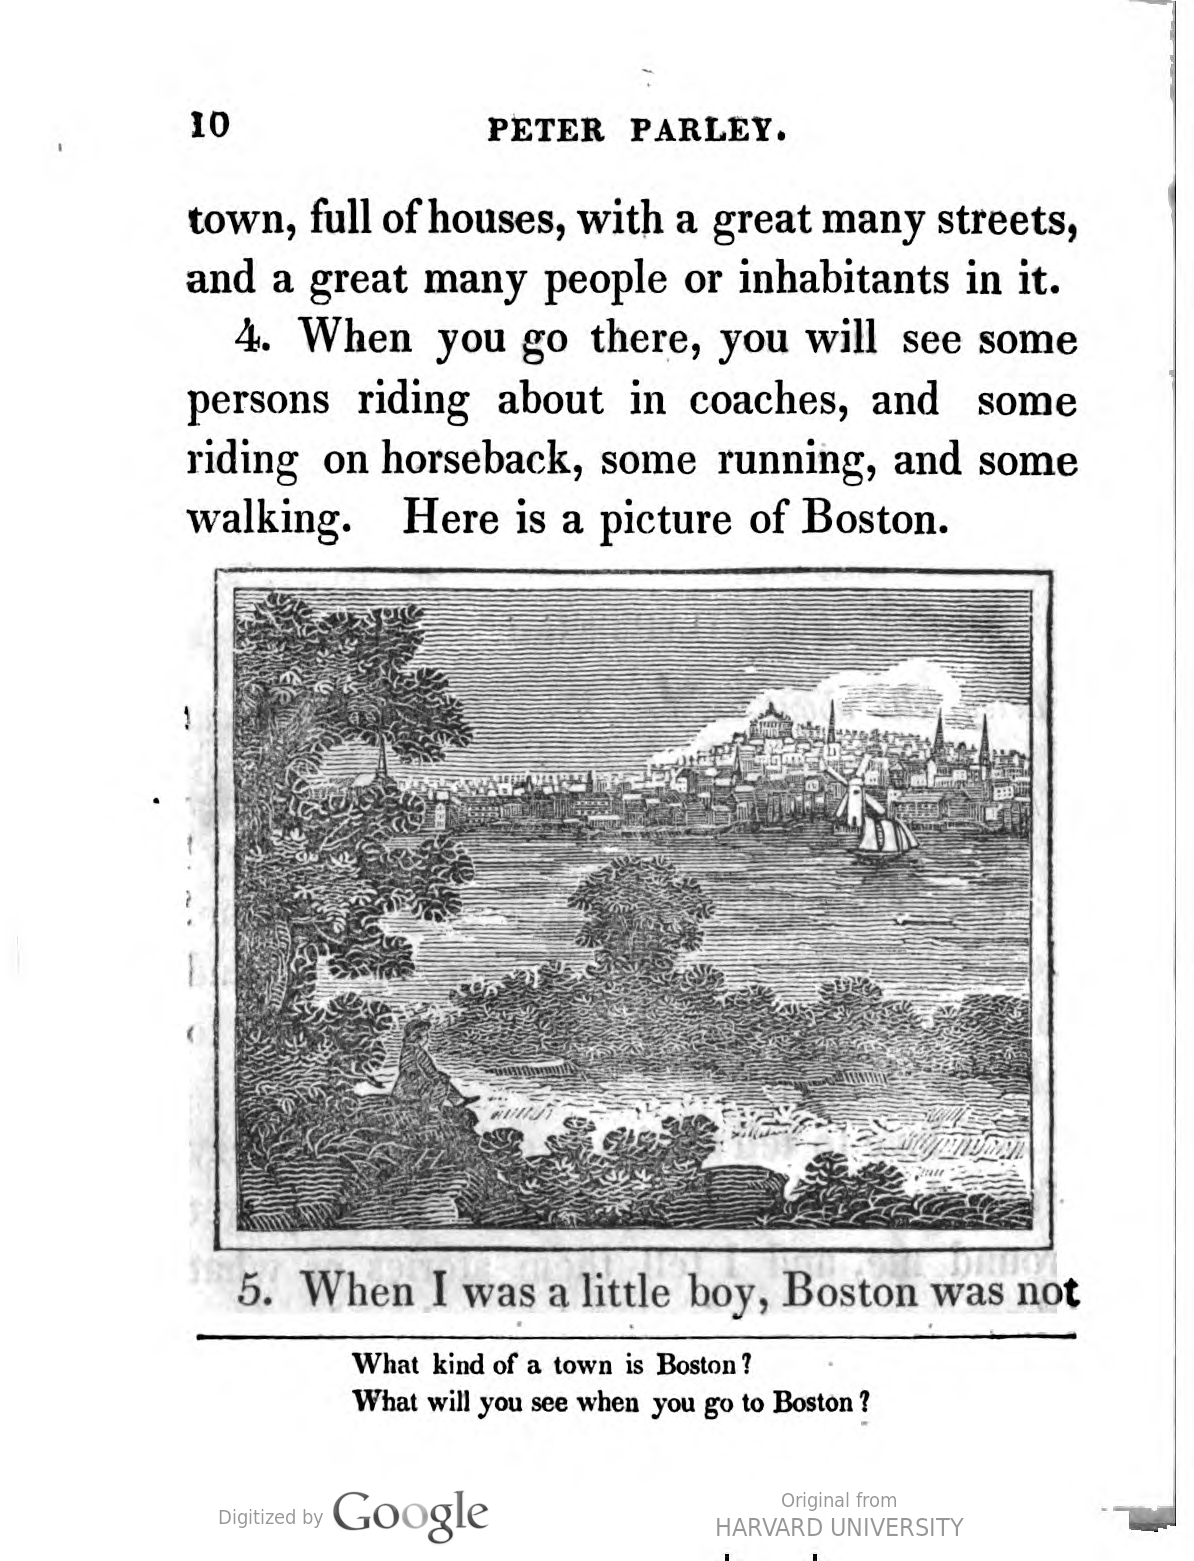

# Word Embeddings

Decisions: pretrained vs. using corpus. See: https://stats.stackexchange.com/questions/268722/word-embedding-generic-corpus-or-specialized-corpus. We could use a big pretrained word2vec corpus, but will stick to a simpler tf-idf scheme.

## Build dictionary from volumes

We need to get all the different tokens occurring in the volume, along with their counts.

In [58]:
# let's build the dictionary; should include full *body* text of all the documents examined (?)
# ok so if you are gonna go lowercase, remember that everything else has to be lowercase
D = parley1830.tokenlist(pages=False,case=False,pos=False,page_freq=False)

# in order to get numeric ids
D = D.reset_index()

# Practice pandas indexing
# https://pandas.pydata.org/pandas-docs/stable/cookbook.html
D.loc[D.lowercase == "america"]

,section,lowercase,count
217,body,america,64


In [59]:
# ensure each token unique: sum over all volumes
counts = defaultdict(lambda: 0)
for vol in fr:
    VTL = vol.tokenlist(pages=False,case=False,pos=False,page_freq=False)
    VTL = VTL.reset_index()
    temp = VTL.to_dict('index')
    for k,v in temp.items():
        counts[v['lowercase']] += int(v['count'])

# mappings for both directions: just use an incrementing index as the ID
id2word = {}
word2id = {}
for i,k in enumerate(counts.keys()):
    id2word[i] = k
    word2id[k] = i
    
# additional brackets since from_corpus method takes a list argument
corpus = [[(word2id[k],v) for k,v in counts.items()]]

In [60]:
# Much easier (for me!) to work with Python dicts
# this one is keyed on the word_id row indices
d = D.to_dict('index')

# gensim takes Python dictionaries; both are keyed on the unique row index (starting at 0)
# the value for id2word is the Unicode string correponding to that id
# the value for corpus is the count (integer) of how many times that word appears in the volume
id2word = {k:v['lowercase'] for k,v in d.items()}

# Watch out! have to make this nested since gensim.Dictionary expects list of lists
corpus = [[(k,int(v['count'])) for k,v in d.items()]]

# https://radimrehurek.com/gensim/corpora/dictionary.html
dct = Dictionary.from_corpus(corpus, id2word=id2word)

## Turn page token counts into BoW format

In [61]:
# tokenlist from the entire volume, preserving page location info
PTL = parley1830.tokenlist(case=False,pos=False)

# loop over all the pages with images, each page becomes doc in BoW format
bow_docs = []
bow_idxs = []
for pg in image_pages:
    # term ids are from the dictionary (which is why we had to build it)
    try:
        bow = [(dct.token2id[k[1]],int(v['count'])) for k,v in PTL.loc[pg].to_dict('index').items()]
        bow_docs.append(bow)
        bow_idxs.append(pg)
    # our old problem: not all pages are in feature-reader due to OCR!
    except KeyError:
        print("Page contains no OCR text:", pg)

# we will compare soft cos w2vec similarities against tf-idf
tfidf_model = TfidfModel(bow_docs)

# as long as size doesn't explode, we can capture pairwise sims with MatrixSimilarity
tfidf_sims = MatrixSimilarity(tfidf_model[bow_docs], num_features=len(dct))

Page contains no OCR text: 1
Page contains no OCR text: 14
Page contains no OCR text: 130


# Visualize page-page semantic similarity

We can do this with Seaborn heatmaps! The matrices are symmetric and the indices are the page numbers from the `parley1830` sequence.

<IPython.core.display.Javascript object>


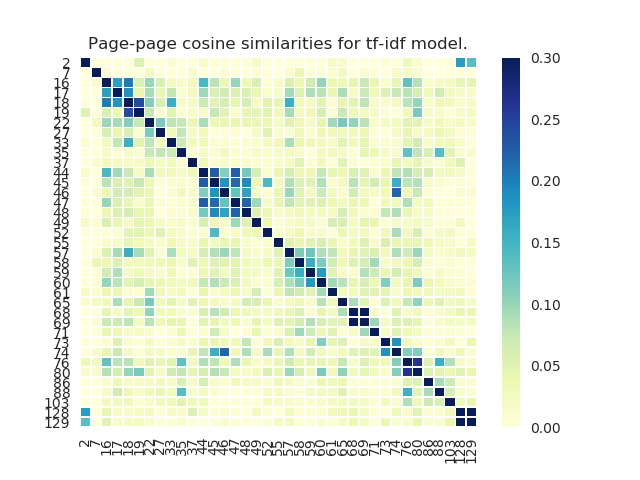

In [62]:
# Check out the other notebook for multi volume workflow
plt.figure()
plt.title("Page-page cosine similarities for tf-idf model.")
sns.heatmap(tfidf_sims,
            xticklabels=bow_idxs,
            yticklabels=bow_idxs,
            vmax=0.3,
            linewidths=0.5,
            cmap="YlGnBu")

The cells in the main diagonal consist of pages compared with themselves in semantic space. They have similarities of 1.0, up to numeric precision. This is a decent sanity check on what we get back from gensim. What about the smaller blocks of darker colors? Blocks along the diagonal are consecutive pages with images. The matrices are completely symmetric about the diagonal: in the tf-idf heatmap, there's a cluster around pp. 44-48. This indicates a section of the book in which each page has an inlined wood engraving and the semantic similarity suggests a relatively homogenous chapter. And indeed, this is a catalog of the customs of the Dutch, French, English, Spanish, Turkish, and Chinese. Simple wood engravings with borders appear on each page. On the page footers, the formulaic question: "Where do the X come from?"

# TODO

- Image downloads (see `download_image_pages.py`)
- Illustration extraction
- MobileNet projection 
- Compare semantic and visual similarities

# Bibliography and further reading

- https://programminghistorian.org/lessons/text-mining-with-extracted-features
- https://radimrehurek.com/gensim/tut2.html
- https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
- https://seaborn.pydata.org/tutorial/distributions.html
- https://htrc.github.io/HTRC-WorksetToolkit/sdk.html#module-htrc.metadata
- http://douglasduhaime.com/posts/identifying-similar-images-with-tensorflow.html